# NewsUK test

This test gives you the opportunity to demonstrate your data analysis and predictive modelling skills.  
 
Two data files are provided, which contain fictitious information about a group of customers and their interactions with a news website:  
 1. ds_test_demog_out.csv​:  This is the output of a SQL query run on a customer database and includes customer ids (uid) and a demographic attribute (attribute_1) recorded for these customers. 
 2. ds_test_log_out.csv​:  This is the output of a SQL query run on a database that contains the event logs for a news website. It includes the customer id (uid) of the customer making the interaction on the website, the date of the interaction, and the name of the website section and the website page that they are interacting with.

Test scenario 
 
You are a data scientist working in Data Technology. Rachel, is the deputy editor for one of our news websites and has come to you and explained that she would like to ​improve the user experience for customers visiting the website by showing more relevant, personalised content
​ to visitors, based on who they are. In particular Rachel would like to promote certain types of news stories to visitors based on a particular demographic attribute.  
 
The challenge for Rachel is that attribute_1 is not very well populated in the customer database, and therefore we can only see it for a subset of visitors who come to the website. ​Rachel wants to know if you (as a data scientist in Data Technology) can reliably predict attribute_1 for visitors to the website where it is not known for a visitor. If feasible, she wants to use a predicted value for attribute_1 for personalising content where attribute_1 is not available. 

Using the two data sets provided: 
1. Assess the feasibility of predicting the value of ​attribute_1​ where it is missing. 
2. Identify which features (that can be extracted from the data) are most important for predicting ​attribute_1​. 

Assume that you have two audiences for your findings: 
- Rachel and her colleagues in the editorial team (who requested the work). 
- Your data science and engineering colleagues (as part of a weekly project review). 

Outputs required from you 
 
Suggested time for this exercise is 2-3 hours. Your outputs should include: 
 
- A few bullet points explaining the findings that you would present to each audience ( Rachel and the editorial team, and your data science colleagues) and any analysis outputs (charts, tables etc) - please put all of these into a single document (e.g. Word, Google Doc or PDF) - or if you prefer, include in the Notebook below. 
- Analysis code in the language of your choice (e.g. Python, R etc) - commented where possible - either raw or in a Notebook (e.g. iPython) 
- Data sets generated as part of the analysis (including any interim and final data sets e.g. data tables / data frames) 
- Any observations / thoughts you have on the nature of this problem, and ideas on how useful this would be in practice for a news website. 
 

In [181]:
#Plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

#Python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Machine Learning packages (not used)
#from sklearn.ensemble import RandomForestRegressor
#import sklearn.metrics as metric
#from scipy.stats import chisquare

In [87]:
#Read Data
df_demo = pd.read_csv('ds_test_demog_out.csv')
df_log = pd.read_csv('ds_test_log_out.csv')
#Check counts of unique UIDs
print len(df_demo.uid.unique())
print len(df_log.uid.unique())

1880
1161


In [ ]:
#Construct a left join. Merging the attribute number to the UIDs that match in the 'log' dataset. 
list_df = [df_demo,df_log]
df = df_log.merge(df_demo, left_on='uid', right_on='uid', how='left')
df.to_csv('ds_test_log+demog_out.csv')

In [266]:
#Explore attributes

#Replace NaN values with numerical value (-1)
df_nan = df.replace(np.nan, -1)
#identify attributes
att = df_nan.attribute_1.unique()
#Group data by attributes
att_1 = df.groupby('attribute_1').get_group(att[0])
att_2 = df.groupby('attribute_1').get_group(att[2])
att_nan = df_nan.groupby('attribute_1').get_group(att[1])
#REPORT 
print 'Total unique UIDs with attributes in log data:', len(att_1.uid.unique())+len(att_2.uid.unique()), ' out of ',len(df_log.uid.unique())

Total unique UIDs with attributes in log data: 827  out of  1161


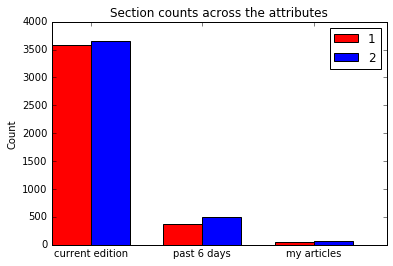

In [267]:
#Plot the sections, by attribute, to assess if there are any demographic trends.
att_1_section_counts = [len(att_1.groupby('section').get_group('current edition')),
                        len(att_1.groupby('section').get_group('past 6 days')),
                        len(att_1.groupby('section').get_group('my articles'))]
att_2_section_counts = [len(att_2.groupby('section').get_group('current edition')),
                        len(att_2.groupby('section').get_group('past 6 days')),
                        len(att_2.groupby('section').get_group('my articles'))]  

labels = ['current edition','past 6 days','my articles']

#PLOT
ind = np.arange(len(labels))
fig, ax = plt.subplots()
rects1 = ax.bar(ind, att_1_section_counts, width=0.35,color='r')
rects2 = ax.bar(ind+0.35, att_2_section_counts, width=0.35, color='b')

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Section counts across the attributes')
ax.set_xticks(ind + 0.35)
ax.set_xticklabels(labels)

ax.legend((rects1[0], rects2[0]), ('1', '2'))
plt.show()

In [268]:
#Predicting method 1. Assign attribute for UID based on the mean
pages = df.page.unique()
page_dict = {}

df_mean = df.iloc[[0]]

for i in pages:
    df_page = df.groupby('page').get_group(i)
    df_page_na = df_page.dropna()
    mean = df_page_na.attribute_1.mean()
    page_dict[i]=int(round(mean,0))

    df_mean_i = df.groupby('page').get_group(i).fillna(int(round(mean,0)))
    df_mean = pd.concat([df_mean,df_mean_i])

df_mean.to_csv('ds_test_log+demog_aggregate_predictions.csv')

In [271]:
#Produce a data frame just users with unknown attributes and replace attributes
df_page_nan = df.iloc[[0]]
pages = att_nan.page.unique()
for i in pages:
    df_page = att_nan.groupby('page').get_group(i)
    df_page_nan_i = df_page.replace(-1, page_dict[i])
    df_page_nan = pd.concat([df_page_nan,df_page_nan_i])
    
df_page_nan = df_page_nan.drop(df.index[0])

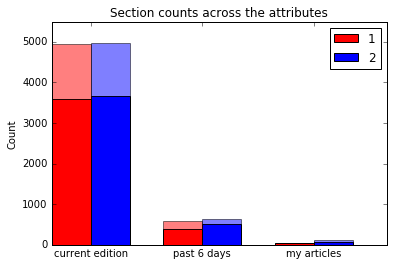

In [272]:
att_1_nan = df_page_nan.groupby('attribute_1').get_group(att[0])
att_2_nan = df_page_nan.groupby('attribute_1').get_group(att[2])

att_1_nan_section_counts = [len(att_1_nan.groupby('section').get_group('current edition')),
                            len(att_1_nan.groupby('section').get_group('past 6 days')),
                            0]
att_2_nan_section_counts = [len(att_2_nan.groupby('section').get_group('current edition')),
                            len(att_2_nan.groupby('section').get_group('past 6 days')),
                            len(att_2_nan.groupby('section').get_group('my articles'))]  

labels = ['current edition','past 6 days','my articles']

#PLOT
ind = np.arange(len(labels))
fig, ax = plt.subplots()

rects1 = ax.bar(ind, att_1_section_counts, width=0.35,color='r')
rects2 = ax.bar(ind+0.35, att_2_section_counts, width=0.35, color='b')
rects3 = ax.bar(ind, att_1_nan_section_counts, bottom=att_1_section_counts, width=0.35,color='r',alpha=0.5)
rects4 = ax.bar(ind+0.35, att_2_nan_section_counts, bottom=att_2_section_counts, width=0.35, color='b',alpha=0.5)

# add some text for labels, title and axes ticks
ax.set_ylabel('Count')
ax.set_title('Section counts across the attributes')
ax.set_xticks(ind + 0.35)
ax.set_xticklabels(labels)
ax.set_ylim([0,5500])

ax.legend((rects1[0], rects2[0]), ('1', '2'))
plt.show()

In [273]:
#Quantify the reliability of predictions by comparing the ratio of counts of for Attributes 1 and 2 
#from the training data and the predicted data.
attribute_ratio_train = []
attribute_ratio_predict = []

for i,j in zip(att_1_section_counts,att_2_section_counts):
    attribute_ratio_train.append(float(i)/float(j))
for i,j in zip(att_1_nan_section_counts,att_2_nan_section_counts):
    attribute_ratio_predict.append(float(i)/float(j))

print 'Attribute count ratio for {} from train = {} and prediction = {}'.format(labels[0],
                                                                          round(attribute_ratio_train[0],2),
                                                                          round(attribute_ratio_predict[0],2))
print 'Attribute count ratio for {} from train = {} and prediction = {}'.format(labels[1],
                                                                          round(attribute_ratio_train[1],2),
                                                                          round(attribute_ratio_predict[1],2))
print 'Attribute count ratio for {} from train = {} and prediction = {}'.format(labels[2],
                                                                          round(attribute_ratio_train[2],2),
                                                                          round(attribute_ratio_predict[2],2))
df_mean.section.value_counts()

Attribute count ratio for current edition from train = 0.98 and prediction = 1.03
Attribute count ratio for past 6 days from train = 0.75 and prediction = 1.57
Attribute count ratio for my articles from train = 0.73 and prediction = 0.0


current edition    9920
past 6 days        1212
my articles         178
Name: section, dtype: int64

In [ ]:
#Random Forrest - will not work with categorical variables. 

#Generate attribute and predictors lists
columns = df.columns
attribute = columns[4]
predictors = columns[:4]

Y_train = df[attribute]
X_train = df[predictors]
#X_test = df_test[predictors]

#Random forrest via Regressor
#Set number of trees (greater N = better predicitons/longer run time)
N = 50
#Train the algorithm on the train data
alg2 = RandomForestRegressor(n_estimators=N, min_samples_split=2, min_samples_leaf=1)
alg2.fit(X_train, Y_train)
#Use trained algorithm to create prediction of the trian
Y_hat2 = alg1.predict(X_train)
#Score Train prediction
score = metric.r2_score(Y_train.values,Y_hat1)
chi_score, pval = chisquare(Y_train.values, Y_hat1)

print 'R-squ:',round(score,3)
print 'Chi-squ:',round(chi_score,-6)